In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf    
from IPython.display import clear_output
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.animation import FuncAnimation
from matplotlib import cm
import seaborn

# Введение в Tensorflow

"Чтобы производить эффективные численные вычисления в Python, обычно используются библиотеки вроде NumPy, которые совершают такие дорогие операции как перемножение матриц вне Python'а, используя крайне эффективный код, реализованный в другом языке. К сожалению, возникает дополнительная нагрузка при переключении обратно в Python после каждой операции. Эта нагрузка особенно заметна когда нужно производить вычисления на GPU или в распределенном режиме, где передача данных является дорогой операцией.

TensorFlow также производит сложные вычисления вне Python, но он идет еще дальше чтобы избежать дополнительной нагрузки. Вместо того, чтобы запускать одну дорогую операцию независимо от Python, TensorFlow позволяет нам описать граф взаимодействующих операций, которые работают полностью вне Python. Схожий подход используется в Theano и Torch."

TensorFlow отличается от Numpy в основном тем, что умеет еще выполнять функции над тензорами и автоматически вычислять производные (ну и, конечно, есть поддержка GPU)

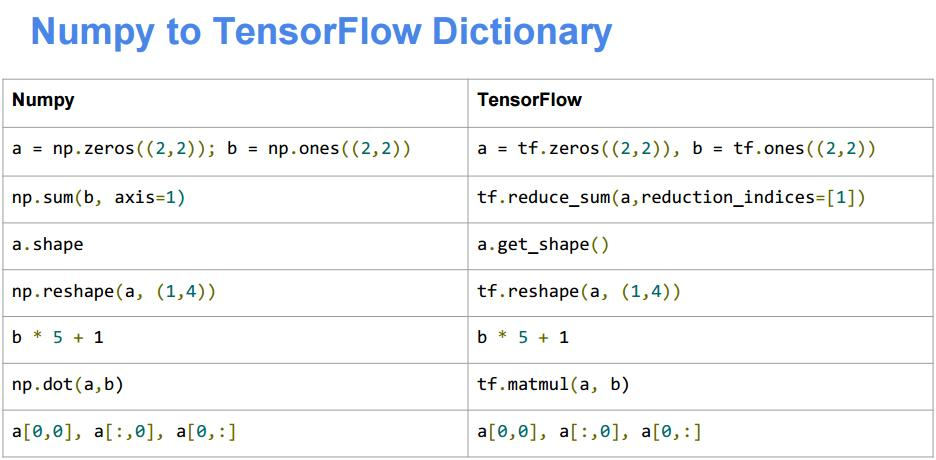

## 1. Граф и сессия

TensorFlow присуще два понятия:
- Граф вычислений
- Сессия

Основная идея заключается в том, чтобы сначала установить правила, по которым производить вычисления, двигаясь по графу, а затем по мере необходимости вычислять процедуры

Graph: Operation + Tensor, то есть:

Узлами графа являются операции, а между узлами перемещаются тензоры (наши данные)


In [ ]:
# получаем доступ к графу
graph = tf.get_default_graph()

# выводим набор операций (узлы графа)
graph.get_operations()

## 2. Простые тензоры

TensorFlow во многом похож на numpy, поэтому здесь ничего нового не будет
- tf.constant - определяем константу
- tf.zeros - заполняем нулями
- tf.ones - заполняем единцами
- tf.fill - заполняем любым числом
- tf.linspace - последовательность float
- tf.range - последовательность int
- tf.random_normal - случайный тензор из нормального распределения

## 3. Переменные - класс Variables

Во-первых, любая переменная требует инициализации, который должен содержать тип и размер тензора

In [ ]:
# структура работы с переменной
x = tf.Variable(0, name='x')

model = tf.global_variables_initializer()
with tf.Session() as session:
    for i in range(5):
        session.run(model)
        x = x + 1
        print(session.run(x))

Что можно делать с Variable?
- tf.add - складывать
- tf.assign - переобозначить новым значением

## 4. Placeholder

Placeholder - это фиктивные узлы, которые предоставляют точки входа для данных в вычислительный граф. 

Мы сказали, что Variables требуют инициализации. Однако иногда требуется вводить данные по мере их поступления (но на данный момент их нет, например), поэтому в данном случае мы даем как бы обещание, что мы потом их внесем, когда это потребуется

# Реализация

In [ ]:
class HeatEquation():
    def __init__(self, nxy, tmax, nt, u0, u0yt, u1yt, ux0t, ux1t):
        self._nxy = nxy    # точек в направлении x, y
        self._tmax = tmax  # масимальное время
        self._nt = nt      # количество моментов времени
        self._u0 = u0      # начальное условие
        
        # краевые условия
        self._u0yt = u0yt 
        self._u1yt = u1yt
        self._ux0t = ux0t
        self._ux1t = ux1t
        
        # шаги по координатам и по времени
        self._h = h = np.array(1./nxy)
        self._ht = ht = np.array(tmax/nt)
        print("ht/h/h:", ht/h/h)

        self._xs = xs = np.linspace(0., 1.,    nxy + 1)
        self._ys = ys = np.linspace(0., 1.,    nxy + 1)
        self._ts = ts = np.linspace(0., tmax,  nt  + 1) 

        from itertools import product
        # узлы сетки, как векторы в пространстве
        # product - декартовое произведение, но в одномерном представлении
        self._vs  = vs  = np.array(list(product(xs, ys)), dtype=np.float64)
        self._vcs = vsc = np.array(list(product(xs[1:-1], ys[1:-1])), dtype=np.float64) # внутренние узлы
        
        # функция, которую будем искать
        self._U_shape    = (nxy+1, nxy+1, nt+1)
        self._U = np.zeros((nxy+1, nxy+1, nt+1)) # выделяем сразу для всех точек и моментов времени,
        self._U[:,:,0] = u0(vs).reshape(self._U_shape[:-1]) # ее значение в нулевой момент времени
    
    # метод, строящий граф
    def build_graph(self, learning_rate):
        def reset_graph():
            if 'sess' in globals() and sess:
                sess.close()
            tf.reset_default_graph()
        
        reset_graph()

        nxy = self._nxy

        # входные параметры
        U_prev_ = tf.placeholder(tf.float64, (nxy+1, nxy+1), name="U_t-1")

        # значение функции в данный момент времени, его и будем искать
        U_ = tf.Variable(U_prev_, trainable=True, name="U_t", dtype=tf.float64)

        # срез тензора
        def s(tensor, frm):
            return tf.slice(tensor, frm, (nxy-1, nxy-1), name="slicing")

        # вычисления действия оператора на u
        Ap_Am_U_  = (s(U_, (1, 1)) ** 2 + s(U_, (2,1)) ** 2) * (s(U_, (2,1)) - s(U_, (1,1)))
        Ap_Am_U_ -= (s(U_, (0, 1)) ** 2 + s(U_, (1,1)) ** 2) * (s(U_, (1,1)) - s(U_, (0,1)))
        Ap_Am_U_ += (s(U_, (1, 1)) ** 2 + s(U_, (1,2)) ** 2) * (s(U_, (1,2)) - s(U_, (1,1)))
        Ap_Am_U_ -= (s(U_, (1, 0)) ** 2 + s(U_, (1,1)) ** 2) * (s(U_, (1,1)) - s(U_, (1,0)))
        Ap_Am_U_ *= 0.5*self._ht/self._h/self._h

        # остатки
        res = s(U_,(1, 1)) - Ap_Am_U_ - s(U_prev_, (1, 1))
        
        # функция потерь, которая будет оптимизироваться
        loss = tf.reduce_sum(tf.square(res), name="loss_res")

        # краевые условия и их влияния на функцию потерь
        u0yt_ = None
        u1yt_ = None
        ux0t_ = None
        ux1t_ = None
        if self._u0yt:        
            u0yt_ = tf.placeholder(tf.float64, (nxy+1,), name="u0yt")
            loss += tf.reduce_sum(tf.square(tf.slice(U_, (0, 0),   (1, nxy+1))
                     - tf.reshape(u0yt_, (1, nxy+1))), name="loss_u0yt")
        if self._u1yt:
            u1yt_ = tf.placeholder(tf.float64, (nxy+1,), name="u1yt")
            loss += tf.reduce_sum(tf.square(tf.slice(U_, (nxy, 0), (1, nxy+1))
                     - tf.reshape(u1yt_, (1, nxy+1))), name="loss_u1yt")
        if self._ux0t:
            ux0t_ = tf.placeholder(tf.float64, (nxy+1,), name="ux0t")
            loss += tf.reduce_sum(tf.square(tf.slice(U_, (0, 0),   (nxy+1, 1))
                     - tf.reshape(ux0t_, (nxy+1, 1))), name="loss_ux0t")
        if self._ux1t:
            ux1t_ = tf.placeholder(tf.float64, (nxy+1,), name="ux1t")
            loss += tf.reduce_sum(tf.square(tf.slice(U_, (0, nxy), (nxy+1, 1))
                     - tf.reshape(ux1t_, (nxy+1, 1))), name="loss_ux1t")
        
        # шаг оптимизации функционала 
        train_step = tf.train.AdamOptimizer(learning_rate, 0.7, 0.97).minimize(loss)

        # возврат операций в словаре, которые будем запускать
        self.g = dict(
            U_prev = U_prev_,
            u0yt = u0yt_,
            u1yt = u1yt_,
            ux0t = ux0t_,
            ux1t = ux1t_,
            U = U_,
            res = res,
            loss = loss,
            train_step = train_step
        )
        return self.g

    # метод возвращающий необходимые данные для запуска графа
    def _get_graph_feed(self, t_i):
        g   = self.g
        ts  = self._ts
        xs  = self._xs
        ys  = self._ys
        vcs = self._vcs
        nxy = self._nxy
        t   = self._ts[t_i]

        d = {g["U_prev"]: self._U[:,:,t_i-1]}

        if g["u0yt"] is not None:
            d[g["u0yt"]] = self._u0yt(ts[t_i-1], ys)
        if g["u1yt"] is not None:
            d[g["u1yt"]] = self._u1yt(ts[t_i-1], ys)
        if g["ux0t"] is not None:
            d[g["ux0t"]] = self._ux0t(ts[t_i-1], xs)
        if g["ux1t"] is not None:
            d[g["ux1t"]] = self._ux1t(ts[t_i-1], xs)
        return d

    # основной метод обучения:
    # в каждый момент времени итерируемся по значениям функции, 
    # пока не превысим maxiter или ошибка не станет меньше eps
    def train_graph(self, eps, maxiter, miniter):
        g = self.g
        losses = []
        # запускам контекст сессии
        with tf.Session() as sess:
            # инициализируем место под данные в графе
            sess.run(tf.global_variables_initializer(), feed_dict=self._get_graph_feed(0))
            for t_i, t in enumerate(self._ts[1:]):
                t_i += 1
                losses_t = []
                losses.append(losses_t)
                d = self._get_graph_feed(t_i)
                p_loss = float("inf")
                for i in range(maxiter):
                    # запускаем граф  и получаем значения u, функции потерь, 
                    _, self._U[:,:,t_i], loss = sess.run([g["train_step"], g["U"], g["loss"]], feed_dict=d)
                    losses_t.append(loss)
                    if i > miniter and abs(p_loss - loss) < eps:
                        p_loss = loss
                        break
                    p_loss = loss
                print(t_i, ' loss: ', loss, i)
        return self._U, losses

    def check_metadata_partitions_graph(self):
        g = self.g
        d = self._get_graph_feed(1)
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer(), feed_dict=d)
            options = tf.RunOptions(output_partition_graphs=True)
            metadata = tf.RunMetadata()
            c_val = sess.run(g["train_step"], feed_dict=d, options=options, run_metadata=metadata)
        print(metadata.partition_graphs)

    def get_U_as_df(self, step=1):
        nxyp  = self._nxy + 1
        nxyp2 = nxyp**2
        Uf = self._U.reshape((nxy+1)**2,-1)[:, ::step]
        data = np.hstack((self._vs, Uf))
        df = pd.DataFrame(data, columns=["x","y"] + list(range(len(self._ts))[0::step]))
        return df

$\tau$ и $h$ следует брать такими, чтобы $\frac{\tau}{h^2}$ было небольшим, желательно, хотя бы < 1, особенно при использовании "негладких" функций.

## Запуск

In [ ]:
tmax = 0.5
nxy  = 100
nt   = 10000

def u0(v):
    return np.zeros([v.shape[0]])

def u0ytb(t, ys):
    return np.sqrt(np.full(fill_value=t, shape=ys.shape[0]))

def ux0tb(t, xs):
    return np.sqrt([(t - np.sqrt(2) * x) if np.sqrt(2) *  x < t else 0 for x in xs])

def u1ytb(t, ys):
    return np.zeros(ys.shape[0])

def ux1tb(t, xs):
    return np.sqrt([(t - np.sqrt(2) * x) if np.sqrt(2) * x < t else 0 for x in xs])


In [ ]:
eq = HeatEquation(nxy, tmax, nt, u0, u0ytb, u1ytb, ux0tb, ux1tb)
_ = eq.build_graph(0.001)

In [ ]:
%%time
U, losses = eq.train_graph(1e-6, 100, 1)

## Визуализация

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from scipy.interpolate import griddata
%matplotlib inline  

data = eq.get_U_as_df(1)

In [ ]:
def make_2d_gif(U, fname, step=1):
    fig = plt.figure(figsize=(10,7))

    zmax = np.max(np.max(U)) + 0.01
    zmin = 0 #np.min(np.min(U)) - 0.01
    norm = matplotlib.colors.Normalize(vmin=zmin, vmax=zmax, clip=False)
    im=plt.imshow(U[:,:,0], interpolation='bilinear', cmap=cm.coolwarm, norm=norm)
    plt.grid(False)
    nst = U.shape[2] // step

    def update(i):
        im.set_array(U[:,:,i*step])
        return im
    
    anim = FuncAnimation(fig, update, frames=range(nst), interval=50)
    anim.save(fname, dpi=80, writer='imagemagick')

In [ ]:
make_2d_gif(U[:,:,:], "test_2d.gif", 100)